In [12]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.pyplot import figure
import pandas as pd

In [2]:
#Download train and test datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
# Size of training and testing data
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [4]:
# Create DataLoaders 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=64, shuffle=False)

In [5]:
# Display the image
def imshow(fashion_img):
    fashion_img = fashion_img / 2 + 0.5  
    npfashion_img = fashion_img.numpy() 
    plt.imshow(np.transpose(npfashion_img, (1, 2, 0)), cmap='gray')
    #plt.title(' '.join(f'{label}' for label in labels))
    plt.show()

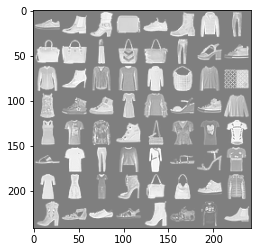

Sneaker Ankle boot Ankle boot Bag Sneaker Ankle boot Coat Trouser


In [6]:
# Get one batch of fashion images and its labels
data_batch_one = iter(train_loader)
fashion_images, labels = data_batch_one.next()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imshow(torchvision.utils.make_grid(fashion_images))
print(' '.join(f'{classes[labels[j]]}' for j in range(8)))

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2_mean = nn.Linear(512, 2)
        self.fc2_logvariance = nn.Linear(512,2)

    def reparameterization(self, mu, logvar):
        std_dev = torch.exp(0.5*logvar)
        eps = torch.randn_like(std_dev) 
        return (eps)*(std_dev)+(mu)
    
    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        mean = self.fc2_mean(x) 
        logvarinace=self.fc2_logvariance(x)
        z = self.reparameterization(mean, logvarinace)
        return z, mean, logvarinace

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 784)
        
    def forward(self,z):
        z = F.relu(self.fc1(z))
        x_reconstruction=torch.sigmoid(self.fc2(z))
        return x_reconstruction

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mean, logvariance = self.encoder(x)
        x_reconstruction=self.decoder(z)
        return x_reconstruction, mean, logvariance

In [10]:
#Load model
model = VAE()
#Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Define Loss 
# Loss = reconstruction loss + KL divergence loss
def loss_function(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

Epoch 1: Train Loss = 328.86264537760417, Test Loss = 288.80370546875
Epoch 2: Train Loss = 281.2615045735677, Test Loss = 278.2448052734375
Epoch 3: Train Loss = 274.94227029622397, Test Loss = 274.32501918945314
Epoch 4: Train Loss = 272.0007015625, Test Loss = 272.48239150390623
Epoch 5: Train Loss = 270.2282165201823, Test Loss = 270.78439594726564
Epoch 6: Train Loss = 268.96227709960937, Test Loss = 269.96912265625
Epoch 7: Train Loss = 268.038725, Test Loss = 268.88288051757814
Epoch 8: Train Loss = 267.2888233154297, Test Loss = 268.26237934570315
Epoch 9: Train Loss = 266.6582171549479, Test Loss = 267.76652839355467
Epoch 10: Train Loss = 266.1389696126302, Test Loss = 267.26021884765623
Epoch 11: Train Loss = 265.64196225585937, Test Loss = 266.94896345214846
Epoch 12: Train Loss = 265.2225667317708, Test Loss = 266.5089221435547
Epoch 13: Train Loss = 264.8702018391927, Test Loss = 266.3614814453125
Epoch 14: Train Loss = 264.52163123372395, Test Loss = 266.4331776611328
Ep

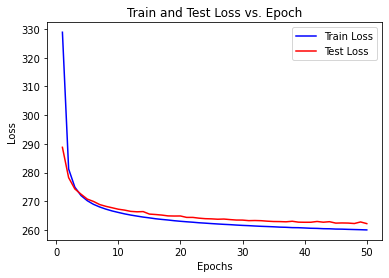

In [11]:
def train_model():
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data
        optimizer.zero_grad()
        x_reconstruction, mean, logvariance = model(data)
        loss = loss_function(x_reconstruction, data, mean, logvariance)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()       
    train_loss /= len(train_loader.dataset)
    return train_loss

def test_model():
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data
            x_reconstruction, mean, logvariance = model(data)
            test_loss += loss_function(x_reconstruction, data, mean, logvariance).item()
    test_loss /= len(test_loader.dataset)
    return test_loss

# Train the model 
num_epochs = 50  
all_train_loss = []
all_test_loss = []

for epoch in range(num_epochs):
    train_loss = train_model()
    test_loss = test_model()
    all_train_loss.append(train_loss)
    all_test_loss.append(test_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss}, Test Loss = {test_loss}")

# Plot the train and test loss
epoch = range(1, num_epochs + 1) 
plt.plot(epoch, all_train_loss, 'b', label='Train Loss')  
plt.plot(epoch, all_test_loss, 'r', label='Test Loss')    
plt.title('Train and Test Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

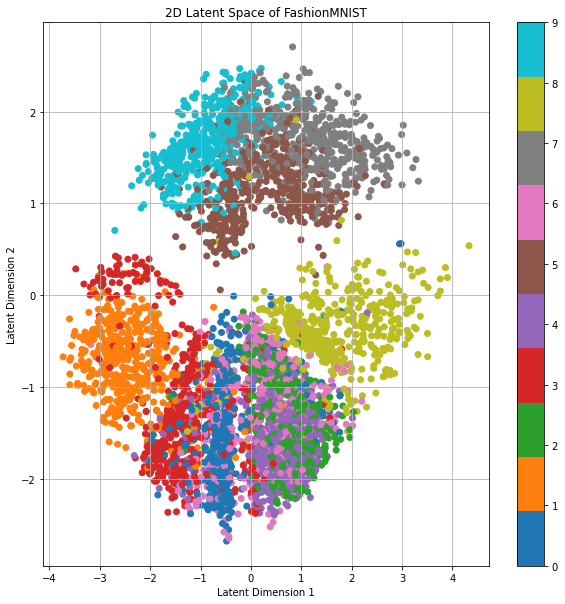

In [13]:
# sample 5000 imges from the dataset
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5000, shuffle=False)

# Get the images
data_iter = iter(subset_loader)
images, labels = next(data_iter)

# Pass images through encoder to get reparameterization
model.eval()
with torch.no_grad():
    z, mean, logvariance = model.encoder(images)
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.title('2D Latent Space of FashionMNIST')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid()
plt.show() 

/tmp/ipykernel_2288789/3210626693.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generate = model.decoder(torch.tensor(z, dtype=torch.float32).unsqueeze(0)).detach().numpy()


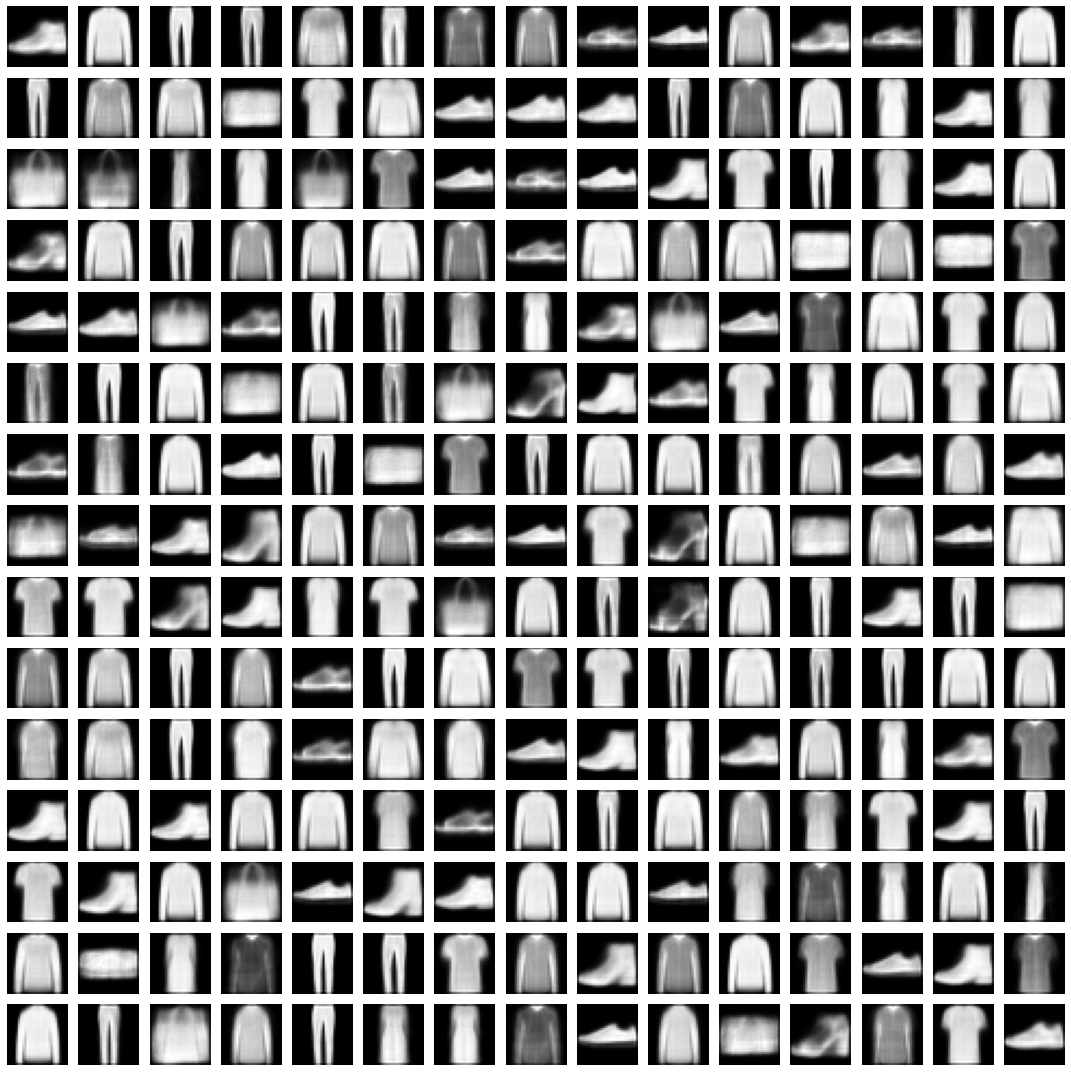

In [14]:
# For z
# sample 5000 imges from the dataset
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5000, shuffle=False)

# Get the images
data_iter = iter(subset_loader)
images, labels = next(data_iter)

#Encoder
z_latent, m, v=model.encoder(images)

x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)

# Generating images using decoder
images_generated_decoder = []
for z in z_latent:
    generate = model.decoder(torch.tensor(z, dtype=torch.float32).unsqueeze(0)).detach().numpy()  
    images_generated_decoder.append(generate.reshape(28, 28))  

fig, axes = plt.subplots(15, 15, figsize=(15, 15))
for i in range(15):
    for j in range(15):
        ax_plot = axes[i, j]
        ax_plot.imshow(images_generated_decoder[i * 15 + j], cmap='gray')
        ax_plot.axis('off')
plt.tight_layout()
plt.show()

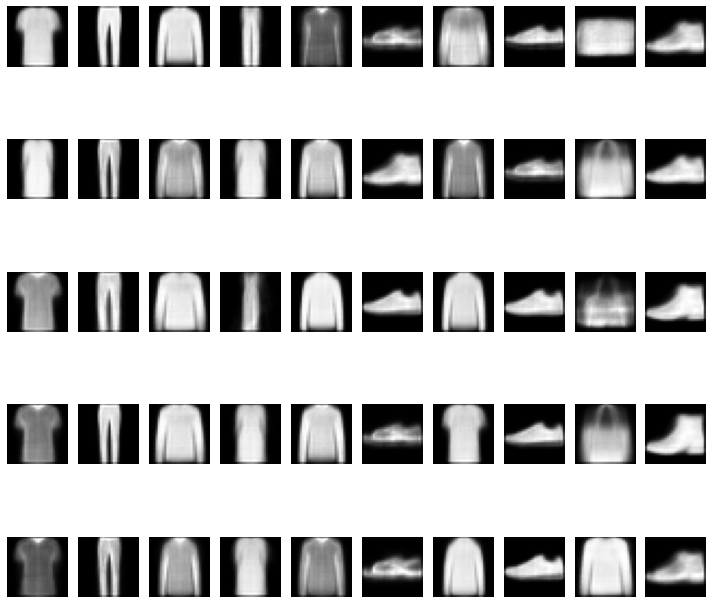

In [15]:
# Sample 5000 images from the dataset
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5000, shuffle=False)
data_iter = iter(subset_loader)
images, labels = next(data_iter)  
categories = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # 10 categories
variation = 5  
row_column = (5, 10)  
generated_images = []

model.eval()
with torch.no_grad():
    for c in categories:
        c_index = (labels == c).nonzero(as_tuple=True)[0]  
        c_img = images[c_index][:variation]  # Select 'num_variations' images
        # Pass each image through the encoder and generate variations
        for img in c_img:
            img = img.unsqueeze(0)  
            z, mean, logvariance = model.encoder(img)
            z_variation = z + torch.randn_like(z) * 0.1  # Add random noise
            generated_image = model.decoder(z_variation).detach().numpy()
            generated_images.append(generated_image.reshape(28, 28))  

generated_images = np.array(generated_images)

# Plot the generated images in a grid
fig, axes = plt.subplots(row_column[0], row_column[1], figsize=(10, 10))
for i in range(row_column[0]):  # row --> variation
    for j in range(row_column[1]):  # column --> categories
        ax = axes[i, j]
        ax.imshow(generated_images[j * variation + i], cmap='gray')
        ax.axis('off')  
plt.tight_layout()
plt.show()
